#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [38]:
from typing import Callable, List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
import random

In [39]:
class Function:

    @staticmethod
    def f(x1, x2):
        return 1.5 - np.exp(-(x1 ** 2) - (x2 ** 2)) - 0.5 * np.exp(-((x1 - 1) ** 2) - ((x2 + 2) ** 2))

In [42]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [40]:
class Chromosome:
  def __init__(self, length, array=None):
    """
    Initialize Chromosome with a binary gene array.
    If no array is provided, it generates a random binary vector of given length.
    """
    self.length = length
    self.array = array if array is not None else [random.randint(0, 1) for _ in range(length)]

  def decode(self, lower_bound, upper_bound, aoi):
    """
    Decode binary vector to a real number within the specified range

    @params
    - lower_bound: Starting index of the binary segment.
    - upper_bound: Ending index of the binary segment.
    - aoi: An two element array representing the range of the decoded real number.

    @returns
    - A real value corresponding to the binary segment, normalized withing specified range.
    """

    bin_vec = self.array[lower_bound:upper_bound + 1]
    dec_val = sum(val * (2 ** idx) for idx, val in enumerate(reversed(bin_vec)))

    min_val, max_val = 0, (2 ** len(bin_vec)) - 1
    return min_max_norm(dec_val, min_val, max_val, *aoi)

  def mutation(self, probability):
    """
    Mutate the gene by flipping the bit with the given probability.

    @params
    - probability: Probability of flipping the bit of the gene.
    """

    if random.random() < probability:
      idx = random.randint(0, len(self.array) - 1)
      self.array[idx] = 0 if self.array[idx] == 1 else 1

  def crossover(self, other):
    """
    Perform one-point crossover with another Chromosome object.

    @params
    - other: Other Chromosome object to crossover with.

    @returns
    - Two Chromosome objects resulting from the crossover.
    """

    assert isinstance(other, Chromosome), "You can only crossover with other Chromosome object."

    rand_idx = random.randint(0, len(self.array) - 1)

    first_child_arr = self.array[:rand_idx] + other.array[rand_idx:]
    second_child_arr = other.array[:rand_idx] + self.array[rand_idx:]

    return Chromosome(self.length, first_child_arr), Chromosome(self.length, second_child_arr)

In [47]:
class GeneticAlgorithm:
  """
  Class implementing genetic algorithm to find the minimum of the given function.
  """

  def __init__(self,
               chromosome_length: int,
               obj_func_num_args: int,
               objective_function: Callable[..., float],
               aoi: List[float],
               population_size: int = 1000,
               tournament_size: int = 2,
               mutation_probability: float = 0.05,
               crossover_probability: float = 0.8,
               num_steps: int = 30
               ):

    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"

    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args

    self.bits_per_arg = int(chromosome_length / obj_func_num_args)

    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps

    self.population = [Chromosome(self.chromosome_lengths) for _ in range(population_size)]

  def eval_objective_func(self, chromosome) -> Dict[Tuple[float, ...], float]:
    """
    Evaluate objective function for a decoded chromosome

    @params
    - chromosome: Chromosome object

    @returns
    - Dictionary of decoded arguments as a key and value of objective function with decoded args as a value
    """

    assert isinstance(chromosome, Chromosome), "You can only pass Chromosome object."

    decoded_args = []
    for i in range(self.obj_func_num_args):
      start_idx = i * self.bits_per_arg
      end_idx = (i + 1) * self.bits_per_arg

      decoded_args.append(
        chromosome.decode(start_idx, end_idx, self.aoi)
      )

    value = self.objective_function(*decoded_args)

    return {tuple(decoded_args): value}

  def tournament_selection(self):
    """
    Perform tournament selection

    @returns
    - Minimum value of the objective function from sampled population
    """
    sample = random.sample(self.population, self.tournament_size)

    sample.sort(key=lambda chromosome: next(iter(self.eval_objective_func(chromosome).values())))

    return sample[0]

  def reproduce(self, parents):
    """
    Create a new population by applying crossover and mutation

    @params
    - parents: Iterable containing two Chromosome objects

    """

    new_population: list = []
    for parent1, parent2 in parents:

      if random.random() < self.crossover_probability:
        child1, child2 = parent1.crossover(parent2)

      else: child1, child2 = parent1, parent2

      child1.mutation(self.mutation_probability)
      child2.mutation(self.mutation_probability)

      new_population.extend([child1, child2])

      if len(new_population) >= len(self.population): # adjust to pop size
        break

    self.population = new_population[:len(self.population)]   # trim to original size

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    """
    Run genetic algorithm for the specified number of generations
    """

    trace = []

    for generation in range(self.num_steps):

      best_chromosome = min(self.population, key=lambda chromosome:
            next(iter(self.eval_objective_func(chromosome).values()))
      )

      result = self.eval_objective_func(best_chromosome)
      best_coded_args = next(iter(result.keys()))
      best_value = next(iter(result.values()))

      trace.append((best_coded_args[0], best_coded_args[1]))
      print(f"Generation {generation}: Best solution = {best_coded_args}, Objective value = {best_value}")

      num_parents = len(self.population) // 2
      parents = [(self.tournament_selection(), self.tournament_selection()) for _ in range(num_parents)]

      # if num_parents is uneven, add new parent
      if len(self.population) % 2 == 1:
          parents.append((self.tournament_selection(), self.tournament_selection()))

      self.reproduce(parents)

    self.plot_func(trace)

Generation 0: Best solution = (0.005405596292722402, 0.022687202432655765), Objective value = 0.4974353244426563
Generation 1: Best solution = (0.016091387605278663, 0.003185938139063911), Objective value = 0.49683486723806264
Generation 2: Best solution = (0.016091387605278663, 0.003185938139063911), Objective value = 0.49683486723806264
Generation 3: Best solution = (0.016091387605278663, 0.003185938139063911), Objective value = 0.49683486723806264
Generation 4: Best solution = (0.009497424113526356, 0.003185938139063911), Objective value = 0.49671058717937366
Generation 5: Best solution = (0.0053101513219567685, 0.008458107282174662), Objective value = 0.4968083875136042
Generation 6: Best solution = (0.001696852968525589, 0.0009356660540508674), Objective value = 0.49663596934578563
Generation 7: Best solution = (0.001696852968525589, 0.0009220322141343376), Objective value = 0.49663576026461936
Generation 8: Best solution = (0.0019515203532869368, 0.0008637300923250921), Objective

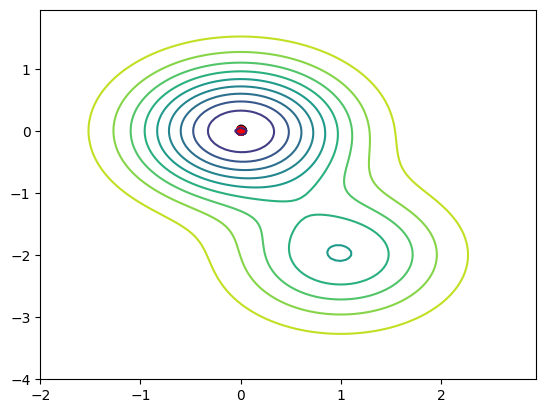

In [41]:
genetic_algorithm = GeneticAlgorithm(128, 2, Function.f, [0, 1])
genetic_algorithm.run()

# Wnioski

## Przy aoi = [0, -1]
Algorytm utknął w minimum lokalnym co wskazuje na problem z doborem zakresu dla zmiennych funkcji celu.
Określenie niewłaściwego zakresu może doprowadzić do zbieżności do minimum lokalnego, zamiast minimum globalnego.

Generation 0: Best solution = (0.5689398083307253, -1.6740592667971725), Objective value = 1.0827488022375542
Generation 1: Best solution = (0.5689398083307253, -1.6740592667971725), Objective value = 1.0827488022375542
Generation 2: Best solution = (0.5689398083307253, -1.6740592749349403), Objective value = 1.0827488014526214
Generation 3: Best solution = (0.5689398083307253, -1.6760589251946243), Objective value = 1.0825562945524123
Generation 4: Best solution = (0.568940553388785, -1.6760589255563616), Objective value = 1.082556091339443
Generation 5: Best solution = (0.568940553388785, -1.6760763974369013), Objective value = 1.0825544126020246
Generation 6: Best solution = (-0.5884824429009328, 0.4654745141323957), Objective value = 0.9303976448229654
Generation 7: Best solution = (-0.5884824429009328, 0.4654742940348484), Objective value = 0.9303975280307941
Generation 8: Best solution = (-0.17031853080277415, -0.10802524344160247), Objective value = 0.5363171266961341
Generation

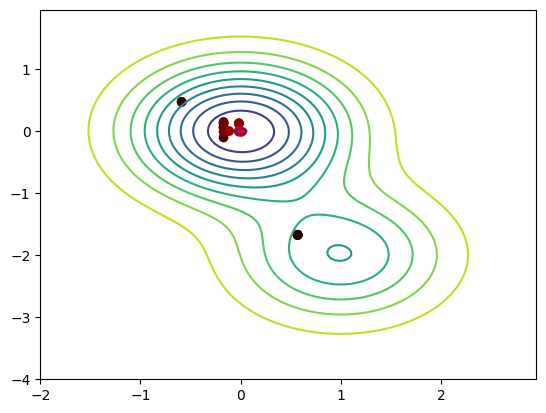

In [44]:
genetic_algorithm = GeneticAlgorithm(128, 2, Function.f, [-50, 50])
genetic_algorithm.run()

Generation 0: Best solution = (0.5105108492433814, 0.33451550956266374), Objective value = 0.809314938052353
Generation 1: Best solution = (0.5105108492433814, 0.33451550956266374), Objective value = 0.809314938052353
Generation 2: Best solution = (-0.1693151224090741, -0.0009096923993041628), Objective value = 0.5259195312346939
Generation 3: Best solution = (-0.055736775761864976, -0.1683246747278062), Objective value = 0.5252248292786368
Generation 4: Best solution = (-0.1693151224090741, -0.006243450037878517), Objective value = 0.5259061960795992
Generation 5: Best solution = (0.13347958308978036, -0.0009096923042193339), Objective value = 0.5133219397730142
Generation 6: Best solution = (0.005858504803569531, -0.008618825121821772), Objective value = 0.4965807391017312
Generation 7: Best solution = (0.005858504803569531, -0.008616572213547613), Objective value = 0.496580731930841
Generation 8: Best solution = (0.005858504803569531, -0.008539086944409746), Objective value = 0.4965

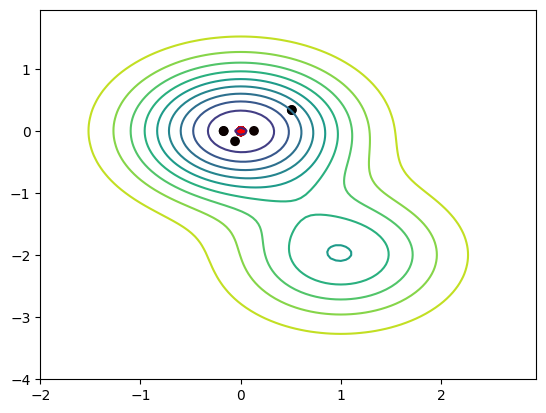

In [43]:
# Greater pop size and more generations

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    population_size=2000,
    tournament_size=5,
    num_steps=100
)
genetic_algorithm.run()


# Wnioski
## Zwiększenie rozmiaru populacji i liczby pokoleń
Algorytm znalazł minimum globalne z dużą dokładnością przy dużej populacji i dużej liczbie pokoleń, lecz
wykonywanie algorytmu zajęło prawię minutę, co przekłada się na dużą złożoność obliczeniową i może doprowadzić do problemów w przypadku większych problemów.

Generation 0: Best solution = (5.988525383144285, -2.3157074253064636), Objective value = 1.4999999999929514
Generation 1: Best solution = (5.988525383144285, -2.3157074253064636), Objective value = 1.4999999999929514
Generation 2: Best solution = (-0.016104565184065223, -32.7402123361304), Objective value = 1.5
Generation 3: Best solution = (21.586900817993026, 1.6839530065665897), Objective value = 1.5
Generation 4: Best solution = (45.06104399490127, -32.74021233613064), Objective value = 1.5
Generation 5: Best solution = (21.586900817993026, 11.760209993024148), Objective value = 1.5
Generation 6: Best solution = (-2.7966441038198653, -2.315707426430457), Objective value = 1.49999787039897
Generation 7: Best solution = (-2.7966441038202206, -2.315707426430457), Objective value = 1.49999787039897
Generation 8: Best solution = (-1.0751824342161242, -2.3171970990476254), Objective value = 1.4924384232133354
Generation 9: Best solution = (5.986336963654928, -2.3138358099532184), Object

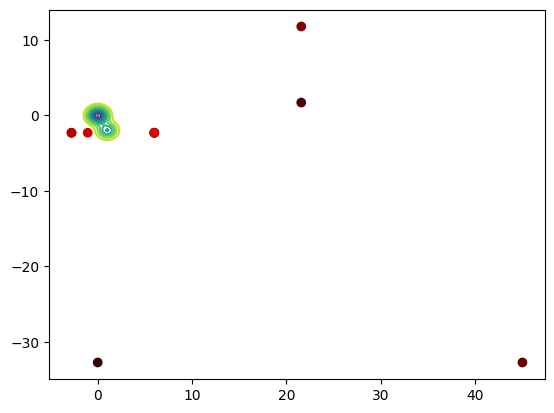

In [49]:
# Smaller pop size and less generations

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    population_size=50,
    num_steps=10
)
genetic_algorithm.run()


# Wnioski
## Zmniejszenie rozmiaru populacji i liczby pokoleń

Algorytm "rozsypał się". Możemy przypuszczać, że zbyt mała liczba populacji i pokoleń drastycznie wpływa na dokładność, ale za to czas wykonywania się algorytmu jest o wiele szybszy.

Generation 0: Best solution = (-0.3024941968313897, -0.6998720690173883), Objective value = 0.9239342970000917
Generation 1: Best solution = (-0.3024941968313897, -0.6998720690173883), Objective value = 0.9239342970000917
Generation 2: Best solution = (1.1832952269508539, 1.6873964717100804), Objective value = 1.4856993798619444
Generation 3: Best solution = (-1.0646233671185215, 1.8272487915746254), Objective value = 1.488578534915687
Generation 4: Best solution = (-0.37223740168490593, 1.8797266593731834), Objective value = 1.474572706349266
Generation 5: Best solution = (1.1832952269645887, -2.6458870835123918), Objective value = 1.1812057815385406
Generation 6: Best solution = (0.7106813387616171, 0.2809237055506273), Objective value = 0.9397988200239975
Generation 7: Best solution = (-0.37223740168490593, 0.2609018298832382), Objective value = 0.6862214833687178
Generation 8: Best solution = (-0.3722374016846146, 0.2693264282933754), Objective value = 0.6898636135660825
Generation

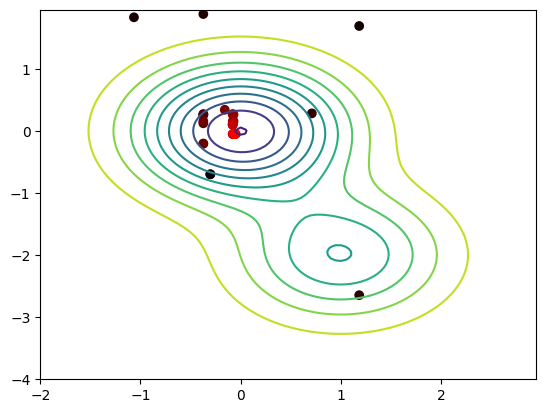

In [48]:
# Low mutation probability

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    mutation_probability=0.01,
)
genetic_algorithm.run()


# Wnioski
## Małe prawdopodobieństwo mutacji

Algorytm przy niskim prawdopodobieństwie mutacji miał tendencję do braku różnorodności i niewielkich zmian w populacji. Z tego wynika, że proces optymalizacji był wolniejszy, a wyniki mniej zróżnicowane. Zbyt mała populacja może ograniczyć zdolność algorytmu do poszukiwania nowych rozwiązań w przestrzeni.

Generation 0: Best solution = (-0.6148035253984645, 0.7239675263112417), Objective value = 1.0942661706336092
Generation 1: Best solution = (-0.6148035253984645, 0.7239675185813468), Objective value = 1.094266166091797
Generation 2: Best solution = (-0.6148035253984645, 0.7239675263095862), Objective value = 1.0942661706326364
Generation 3: Best solution = (-0.6148035253984645, 0.1805718237877656), Objective value = 0.8364235850406097
Generation 4: Best solution = (-0.6137951160806594, -0.1209415476808573), Objective value = 0.8227882878720489
Generation 5: Best solution = (-0.6137951160806594, -0.11822418835878779), Objective value = 0.8223597371393517
Generation 6: Best solution = (0.05319725023327493, -0.11360585110676169), Objective value = 0.5098024347135088
Generation 7: Best solution = (-0.6137951160806594, -0.11822418835878779), Objective value = 0.8223597371393517
Generation 8: Best solution = (0.05320210600461195, -0.11360592621557686), Objective value = 0.5098029050219935
Ge

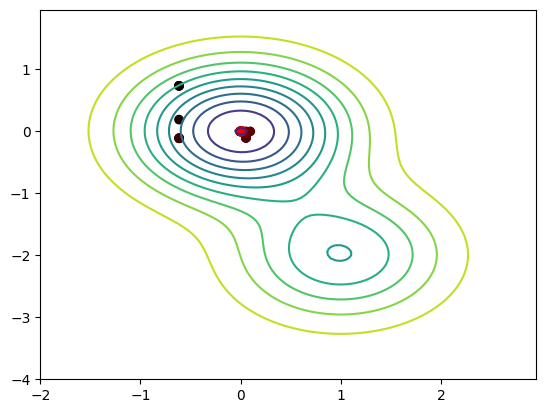

In [45]:
# High crossover probability

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    crossover_probability=0.95,
)
genetic_algorithm.run()


# Wnioski
## Duże prawdopodobieństwo krzyżowania

Algorytm przy wysokim prawdopodobieństwie krzyżowania pokazywał większą różnorodność w swej populacji, co przyśpieszyło proces zbieżności. Mimo wszystko, zbyt wysokie prawdopodobieństwo krzyżowania mogło zbytnio przyspieszać wymianę genów, co zmiejsza tempo odkrywania optymalnych rozwiązań w przestrzeni.

Generation 0: Best solution = (0.29443614799976103, -2.158154061569803), Objective value = 1.194879726589539
Generation 1: Best solution = (0.29443614799976103, -2.158154061569803), Objective value = 1.194879726589539
Generation 2: Best solution = (0.2543425197391471, -2.1567234999784617), Objective value = 1.2112599955645251
Generation 3: Best solution = (-0.39617418749647726, -0.045806422313447115), Objective value = 0.6454854509226093
Generation 4: Best solution = (-0.39617418749647726, -0.045806422313447115), Objective value = 0.6454854509226093
Generation 5: Best solution = (-0.39617418749647726, -0.045806422313447115), Objective value = 0.6454854509226093
Generation 6: Best solution = (0.25432706372422587, -0.045806422313447115), Objective value = 0.5583047891472582
Generation 7: Best solution = (0.2543425197393745, -0.002735715252832449), Objective value = 0.557339409711473
Generation 8: Best solution = (0.24460536154318646, -0.06313411406924274), Objective value = 0.55518779869

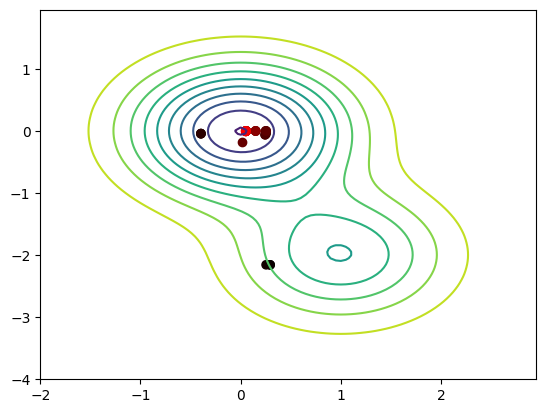

In [46]:
# High mutation probability

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    mutation_probability=0.01,
)
genetic_algorithm.run()

# Wnioski
## Duże prawdopodobieństwo mutacji

Algorytm przy wysokim prawdopodobieństwie mutacji pokazywał dużą niestabilność swojej populacji, co skutkowało większym chaosem w poszukiwaniach. Nie oznacza to konkretnie, że wyniki były gorsze, lecz czasami mutacje były zbyt intensywne, co mogło zakłócić zbieżność do minimum.

Generation 0: Best solution = (-0.4962959006950456, 0.4020752269779493), Objective value = 0.8348376534720056
Generation 1: Best solution = (0.6427813932906616, -0.11062790875104866), Objective value = 0.8341011000020426
Generation 2: Best solution = (-0.4962959006950456, 0.4020752269779493), Objective value = 0.8348376534720056
Generation 3: Best solution = (-0.4962959006950456, 0.4020752269779493), Objective value = 0.8348376534720056
Generation 4: Best solution = (-0.4962959006950456, 0.4020752269779493), Objective value = 0.8348376534720056
Generation 5: Best solution = (0.7076317415751774, 0.42496375982299384), Objective value = 0.9927775094629693
Generation 6: Best solution = (-0.4993476817907876, 0.026703288319218643), Objective value = 0.7203783343171811
Generation 7: Best solution = (-0.4962959006950456, 0.26321812771801234), Objective value = 0.7703262938134274
Generation 8: Best solution = (-0.0980384677007109, 0.4020752269779493), Objective value = 0.656943860261621
Generat

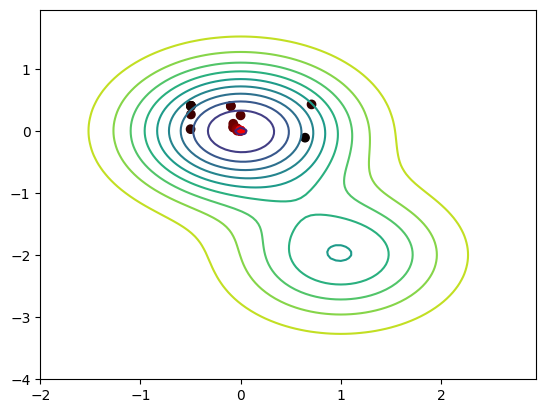

In [50]:
# Shorter chromosome length

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=32,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50]
)
genetic_algorithm.run()

# Wnioski
## Krótsza długość chromosomu

Krótsza długość chromosomu znacząco zmniejszyła czas na obliczenia algorytmu, ale również zmiejszyła dokładność algorytmu. Z tego wynika, że mimo szybkiego działania algorytm nie osiągnął rozwiązania o wysokiej dokładności, co daje nam do zrozumienia, że im dłuższy chromosom, tym dokładniejsze wyniki.

# Wnioski ogólne

Algorytm genetyczny jest to algorytm optymalizacyjny wykorzystujący elementy losowości, takie jak selekcja turniejowa, prawdopodobieństwo mutacji i krzyżowania jednopunktowego. Pozwala to na stworzenie kolejnych pokoleń rozwiązań, które coraz lepiej przystosowane są do rozwiązania danego problemu, stopniowo zbliżając się do, w tym wypadku, minimum globalnego.

Porównując algorytm genetyczny z metodą gradientu prostego, możemy zauważyć, że algorytm genetyczny charakteryzuje się większą odpornością na problemu związane z występowaniem wielu ekstremów lokalnych. Podczas gdy gradient prosty często zatrzymywał się w ekstremach lokalnych, algorytm genetyczny dzięki zastosowaniu losowości może skuteczniej odnajdować ekstrema globalne. Metoda gradientowa wymaga różniczkowalności funkcji celu, ponieważ polega na analizie jej pochodnych w celu kierunkowego poszukiwania minimum. To powoduje, że gradient prosty sprawdza się najlepiej w przypadku funkcji gładkich, wypukłych lub o prostym ukształtowaniu przestrzeni poszukiwań.

W przypadku funkcji o bardziej złożonej topologii, zwłaszcza nieliniowych i z wieloma minimami lokalnymi, algorytm genetyczny ma istotną przewagę, ponieważ nie zależy od pochodnych funkcji celu. Wykorzystując losowość oraz operacje mutacji i krzyżowania, algorytm ten skutecznie przeszukuje przestrzeń rozwiązań, zwiększając szanse na odnalezienie minimum globalnego, nawet gdy inne metody, takie jak gradient, zawodzą.